<a href="https://colab.research.google.com/github/lorrespz/Image-Classification-Collection/blob/main/Custom_ResNet_model_for_BloodCell_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Custom ResNet model for BloodCell dataset

This notebook is from the Lazy Programmer's lecture in the series 'Advanced Convolutional Neural Networks'.

In this notebook, we will implement the ResNet architecture from scratch. The main building blocks of the ResNet model are

- Identity block: this contains 2 branches, one branch being the input itself (identity), and the other branch contains the following sequence: Conv-BN-Relu-Conv-BN-Relu-Conv-BN. The 2 branches are added together before a ReLu activation is applied.

- Convolutional block: this also contains 2 branches, with the shortcut branch consisting of 1 Conv-BN, and the other branch consisting of Conv-BN-Relu-Conv-BN-Relu-Conv-BN. The 2 branches are added together before a ReLu activation is applied.

In [1]:
import tensorflow as tf
from tensorflow.keras import layers as L
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import  ImageDataGenerator
from tensorflow.keras.models import Model


In [2]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob

# Load dataset: Blood cell dataset

In [3]:
#configs
image_size = [224,224]
epochs = 16
batch_size = 128


In [4]:
!wget -nc https://archive.org/download/blood_cell_images/blood_cell_images.zip

--2024-04-03 10:07:17--  https://archive.org/download/blood_cell_images/blood_cell_images.zip
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia801204.us.archive.org/14/items/blood_cell_images/blood_cell_images.zip [following]
--2024-04-03 10:07:18--  https://ia801204.us.archive.org/14/items/blood_cell_images/blood_cell_images.zip
Resolving ia801204.us.archive.org (ia801204.us.archive.org)... 207.241.228.24
Connecting to ia801204.us.archive.org (ia801204.us.archive.org)|207.241.228.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109834540 (105M) [application/zip]
Saving to: ‘blood_cell_images.zip’

blood_cell_images.z 100%[===================>] 104.75M  1.93MB/s    in 18s     

2024-04-03 10:07:36 (5.80 MB/s) - ‘blood_cell_images.zip’ saved [109834540/109834540]



In [5]:
!unzip -nq blood_cell_images.zip

In [6]:
!ls

blood_cell_images  blood_cell_images.zip  __MACOSX  sample_data


In [7]:
train_path = 'blood_cell_images/TRAIN'
valid_path = 'blood_cell_images/TEST'
image_files = glob(train_path + '/*/*.jp*g')
val_image_files = glob(valid_path + '/*/*.jp*g')
#getting the number of classes for classification
folders = glob(train_path+'/*')


In [8]:
# Check several images
print(f'There are {len(image_files)} trained images')
print(f'There are {len(val_image_files)} test images')
print(f'There are {len(folders)} classes for classification')

image_files[:4], val_image_files[:4],   folders

There are 9957 trained images
There are 2487 test images
There are 4 classes for classification


(['blood_cell_images/TRAIN/MONOCYTE/_11_6488.jpeg',
  'blood_cell_images/TRAIN/MONOCYTE/_7_7585.jpeg',
  'blood_cell_images/TRAIN/MONOCYTE/_7_7226.jpeg',
  'blood_cell_images/TRAIN/MONOCYTE/_6_9077.jpeg'],
 ['blood_cell_images/TEST/MONOCYTE/_3_1645.jpeg',
  'blood_cell_images/TEST/MONOCYTE/_2_4994.jpeg',
  'blood_cell_images/TEST/MONOCYTE/_3_276.jpeg',
  'blood_cell_images/TEST/MONOCYTE/_3_9310.jpeg'],
 ['blood_cell_images/TRAIN/MONOCYTE',
  'blood_cell_images/TRAIN/LYMPHOCYTE',
  'blood_cell_images/TRAIN/EOSINOPHIL',
  'blood_cell_images/TRAIN/NEUTROPHIL'])

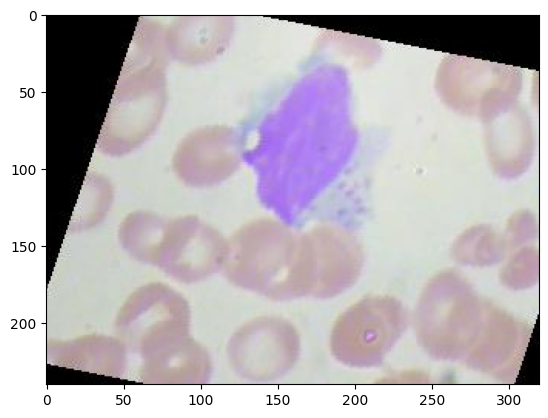

In [9]:
plt.imshow(image.load_img(np.random.choice(image_files)))

# ImageDataGenerator

In [10]:
# define a function to scale the pixel values between -1 and +1
def preprocess_input(x):
  x/=127.5
  x-=1.
  return x

In [11]:
train_gen = ImageDataGenerator(rotation_range = 20, width_shift_range = 0.1,
                               height_shift_range = 0.1, shear_range = 0.1, zoom_range = 0.2,
                               horizontal_flip = True, vertical_flip = True, preprocessing_function = preprocess_input)

val_gen = ImageDataGenerator(preprocessing_function = preprocess_input)

In [12]:
test_gen = val_gen.flow_from_directory(valid_path, target_size = image_size, class_mode = 'sparse')
print(test_gen.class_indices)

Found 2487 images belonging to 4 classes.
{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}


In [13]:
labels = [None]*len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

labels

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

In [14]:
#print out some information from test_gen
for x, y in test_gen:
  print(x.shape, y.shape)
  print(x[0].shape, y[0])
  break


(32, 224, 224, 3) (32,)
(224, 224, 3) 1.0


min: -1.0 max: 1.0


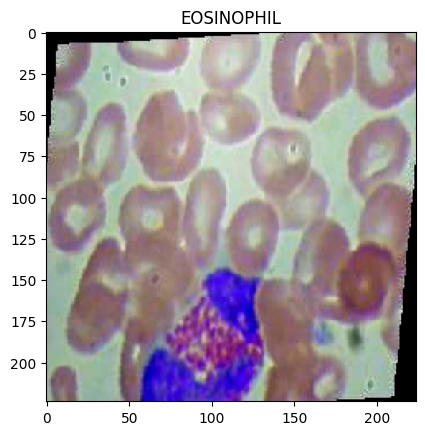

In [15]:
#print out an image from test_gen
for x, y in test_gen:
  print('min:', x[0].min(), 'max:', x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  break


In [16]:
# create generators
train_generator = train_gen.flow_from_directory(train_path, target_size = image_size,
                                                shuffle = True, batch_size = batch_size,
                                                class_mode = 'sparse')
val_generator = val_gen.flow_from_directory(valid_path, target_size = image_size,
                                                shuffle = True, batch_size = batch_size,
                                                class_mode = 'sparse')

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


The train images have shape (128, 224, 224, 3),and the labels have shape (128,)
The first image is


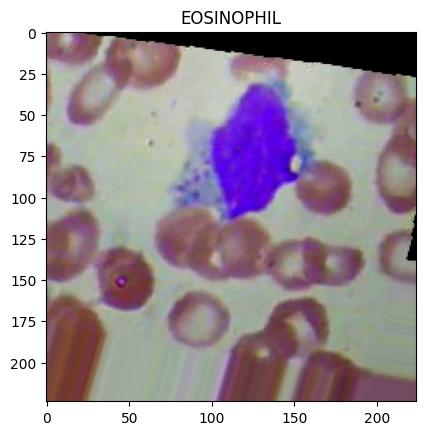

In [17]:
#print out some information from train_gen
for x, y in train_generator:
  print(f'The train images have shape {x.shape},and the labels have shape {y.shape}')
  print('The first image is')
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  break


# ResNet model from scratch

In [18]:
def identity_block(input_, kernel_size, filters):
  f1, f2, f3 = filters
  #1st convolution
  x = L.Conv2D(f1, (1,1),)(input_)
  x = L.BatchNormalization()(x)
  x = L.Activation('relu')(x)
  #2nd convolution
  x = L.Conv2D(f2, kernel_size, padding = 'same')(x)
  x = L.BatchNormalization()(x)
  x = L.Activation('relu')(x)
  #3rd convolution
  x = L.Conv2D(f3, (1,1), )(x)
  x  = L.BatchNormalization()(x)

  #add the original input, then apply 'relu'
  x = L.add([x, input_])
  x = L.Activation('relu')(x)

  return x

In [19]:
def conv_block(input_, kernel_size, filters, strides = (2,2)):
  f1, f2, f3 = filters
  #MAIN BRANCH
  #1st convolution
  x = L.Conv2D(f1, (1,1), strides = strides)(input_)
  x = L.BatchNormalization()(x)
  x = L.Activation('relu')(x)
  #2nd convolution
  x = L.Conv2D(f2, kernel_size, padding = 'same')(x)
  x = L.BatchNormalization()(x)
  x = L.Activation('relu')(x)
  #3rd convolution
  x = L.Conv2D(f3, (1,1), )(x)
  x  = L.BatchNormalization()(x)

  #SHORTCUT BRANCH
  shortcut = L.Conv2D(f3, (1,1), strides = strides,)(input_)
  shortcut = L.BatchNormalization()(shortcut)

  #ADD THE 2 BRANCHES TOGETHER, then apply 'relu'
  x = L.add([x, shortcut])
  x = L.Activation('relu')(x)

  return x

In [20]:
#PUTTING THE BLOCKS TOGETHER TO FORM THE CUSTOM RESNET
i = L.Input(shape = image_size + [3])
x = L.ZeroPadding2D(padding = (3,3))(i)
x = L.Conv2D(64, (7,7), strides = (2,2), padding = 'valid')(x)
x = L.BatchNormalization()(x)
x = L.Activation('relu')(x)
x = L.ZeroPadding2D(padding = (1,1))(x)
x = L.MaxPooling2D((3,3), strides = (2,2))(x)


# 1 conv_block + 2ID blocks
x = conv_block(x, 3, [64,64,256], strides = (1,1))
x = identity_block(x, 3, [64,64,256])
x = identity_block(x, 3, [64,64,256])

# 1 conv_block + 3ID blocks
x = conv_block(x, 3, [128,128,512])
x = identity_block(x,3, [128,128,512])
x = identity_block(x,3, [128,128,512])
x = identity_block(x,3, [128,128,512])

# add the custom head of the network
x = L.Flatten()(x)
pred = L.Dense(len(folders), activation = 'softmax')(x)

model = Model(inputs = i, outputs = pred)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         9472      ['zero_padding2d[0][0]']      
                                                                                                  
 batch_normalization (Batch  (None, 112, 112, 64)         256       ['conv2d[0][0]']          

In [21]:
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = Adam(learning_rate = 0.0001),
              metrics = ['accuracy'])

# Train loop

In [23]:
checkpt_path = '/tmp/checkpoint'
cb1 = tf.keras.callbacks.ModelCheckpoint(filepath = checkpt_path,
                                                             save_weights_only = True,
                                                             monitor = 'val_accuracy',
                                                             mode = 'max',
                                                             save_best_only = True)
cb2 = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 3, restore_best_weights = True)

r = model.fit(train_generator, validation_data = val_generator,
              epochs = epochs,
              steps_per_epoch = len(image_files)//batch_size,
              validation_steps = len(val_image_files)//batch_size,
              callbacks = [cb1, cb2])

Epoch 1/16
77/77 [==============================] - 194s 2s/step - loss: 7.5191 - accuracy: 0.2777 - val_loss: 1.5767 - val_accuracy: 0.2488
Epoch 2/16
77/77 [==============================] - 151s 2s/step - loss: 1.9894 - accuracy: 0.4424 - val_loss: 2.0410 - val_accuracy: 0.2595
Epoch 3/16
77/77 [==============================] - 149s 2s/step - loss: 1.1368 - accuracy: 0.6552 - val_loss: 5.2335 - val_accuracy: 0.2784
Epoch 4/16
77/77 [==============================] - 148s 2s/step - loss: 0.6298 - accuracy: 0.8083 - val_loss: 14.7712 - val_accuracy: 0.2644
Epoch 5/16
77/77 [==============================] - 148s 2s/step - loss: 0.4634 - accuracy: 0.8614 - val_loss: 16.2258 - val_accuracy: 0.2356
Epoch 6/16
77/77 [==============================] - 148s 2s/step - loss: 0.4681 - accuracy: 0.8852 - val_loss: 14.5790 - val_accuracy: 0.3191
Epoch 7/16
77/77 [==============================] - 148s 2s/step - loss: 0.3569 - accuracy: 0.9107 - val_loss: 4.4198 - val_accuracy: 0.6937
Epoch 8/16

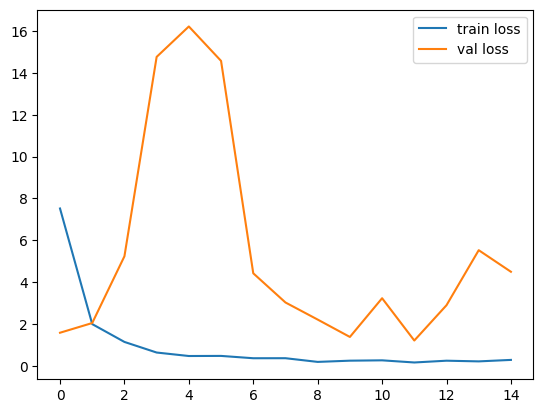

In [24]:
plt.plot(r.history['loss'], label = 'train loss')
plt.plot(r.history['val_loss'], label = 'val loss')
plt.legend()
plt.show()

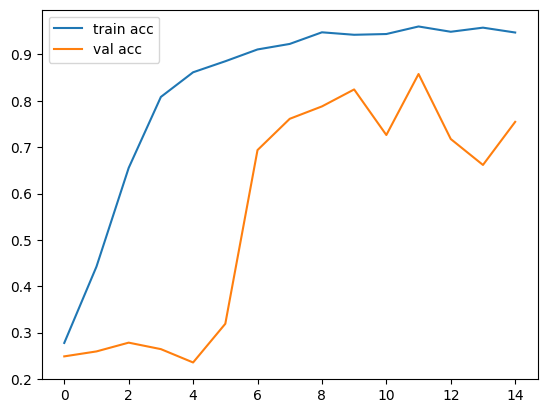

In [27]:
plt.plot(r.history['accuracy'], label = 'train acc')
plt.plot(r.history['val_accuracy'], label = 'val acc')
plt.legend()
plt.show()

In [24]:
# Get the best model in the training process (so that regardless of the last result, we always get the best model)
model.load_weights(checkpt_path)

# Confusion matrix

In [25]:
def get_confusion_matrix(data_path, N):
  preds = []
  targets = []
  i = 0
  for x, y in val_gen.flow_from_directory(data_path, target_size = image_size, shuffle = False):
    i+=1
    if i%50==0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis = 1)
    y = np.argmax(y, axis = 1)
    preds = np.concatenate((preds, p))
    targets = np.concatenate((targets, y))
    if len(targets)>=N:
      break

  cm = confusion_matrix(targets, preds)
  return cm

In [26]:
cm = get_confusion_matrix(train_path, len(image_files))
val_cm = get_confusion_matrix(valid_path, len(val_image_files))

Found 9957 images belonging to 4 classes.
1/1 [==============================] - 0s 30ms/step
50
1/1 [==============================] - 0s 28ms/step
100
1/1 [==============================] - 0s 30ms/step
150
1/1 [==============================] - 0s 29ms/step
200
1/1 [==============================] - 0s 40ms/step
250
1/1 [==============================] - 0s 29ms/step
300
1/1 [==============================] - 1s 899ms/step
Found 2487 images belonging to 4 classes.
1/1 [==============================] - 0s 30ms/step
50
1/1 [==============================] - 1s 829ms/step
[[2370   53    1   73]
 [   0 2483    0    0]
 [   0  245 2233    0]
 [ 164   41   60 2234]]
[[494   7   0 122]
 [  0 618   0   2]
 [ 63   4 548   5]
 [118   2  30 474]]


(None, None)

In [31]:
print(f'Train confusion matrix:')
print(cm)
print('\n')
print(f'Test confusion matrix')
print(val_cm)

Train confusion matrix:
[[2370   53    1   73]
 [   0 2483    0    0]
 [   0  245 2233    0]
 [ 164   41   60 2234]]


Test confusion matrix
[[494   7   0 122]
 [  0 618   0   2]
 [ 63   4 548   5]
 [118   2  30 474]]


In [37]:
train_acc = np.trace(cm)/np.sum(cm)
test_acc = np.trace(val_cm)/np.sum(val_cm)
print(f'Train acc: {train_acc*100:.3f}, Test acc: {test_acc*100:.3f}')

Train acc: 93.602, Test acc: 85.806
